In [1]:
# Standard Imports
import os
import pandas as pd
import numpy as np
import warnings
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, log_loss

warnings.simplefilter("ignore")

%matplotlib inline

**Hypothesis:**
* Can we destinguish between each individual?
* Can we classify each person by its gender?
* Can we classify each person who wears glasses?
* Can we classify each person who has facial hair?
* Who's face resembles the "mean" face?

- What happens if we rotate our images 180$^\circ$? Will the classifier be able to predict our new data as well?

In [2]:
# Helper Functions
'''
In the given dataset we are given 40 different individuals,
therefore we iterate over 40 folders and extract each individuals' images
'''
def read_images():
    path = 'orl_faces/'
    X = []
    y = []
    for i in range(40):
        for j in range(10):
            img = Image.open(os.path.join(path, 's' + str(i + 1), str(j + 1) + '.pgm'))
            X.append(np.asarray(img, dtype=np.uint8).flatten())
            y.append(i)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X, pd.Series(data=y, name='target')

X, y = read_images()

Instead of calling and preparing a classifier each time, lets build a simpler way to make it more accessable and friendly:

In [3]:
class ModelCreator:
    def __init__(self,model_name, data, target):
        self.model_name = model_name
        self.data = data
        self.target = target
        
    def split(self, data, target, test_size = 0.2, random_state = 42):
        return train_test_split(data, target, test_size=test_size, random_state=random_state)
    
    def binary_labeling(self, subjects):
        binary_y = np.zeros((y.shape[0],))
        for subj in subjects:
            indice_list = np.where(y == subj)[0]
            binary_y[indice_list] = 1

        return pd.Series(data=binary_y, name='target')
    
    def fit_model(self, model_name, data, target, params):
        print("Fitting Model:\n{}".format(model_name))
        self.model_name = model_name
        self.data = data
        self.target = target
        self.params = params

        if model_name == 'logistic_regression':
            clf = LogisticRegression(random_state=params['random_state'], C=params['C'], multi_class='ovr')
        elif model_name == 'rbf_svm':
            clf = SVC(random_state=params['random_state'], C=params['C'], kernel='rbf', gamma=params['gamma'])
        elif model_name == 'poly_svm':
            clf = SVC(random_state=params['random_state'], C=params['C'], kernel='poly', gamma=params['gamma'])
        elif model_name == 'linear_svm':
            clf = LinearSVC(random_state=params['random_state'], C=params['C'], multi_class='ovr')
        else:
            raise ValueError('\nInvalid model name, please choose between:\n["logisitc_regression", "rbf_svm", "poly_svm", "linear_svm"]')
        clf.fit(data, target)

        return clf
    
    def evaluate(self, classifier, data, target):
        print("\nEvaluating Model:")
        self.clf = clf
        self.data = data
        self.target = target
        print("Model Accuracy Score:", clf.score(data, target))

        print("\n# === Confusion Matrix === #")
        print("",confusion_matrix(y_pred = clf.predict(data), y_true=target))
        print("\n\t\t# === Classification Report === #\n\n",classification_report(y_true = target, y_pred = clf.predict(data)))
        
    def coefs(self, classifier, data, top_N = 10):
        cols = np.arange(data.shape[1])
        xtrain = pd.DataFrame(data=data, columns=cols)
        coef = list(sorted(zip(xtrain.columns,abs(classifier.coef_[0])),key=lambda x: x[1]))
        coef_table = pd.DataFrame(np.array(coef).reshape(-1,2),columns=['Attributes','Coefficient'])
        print('Coefficient for top {} features:\n'.format(top_N))
        print(coef_table.iloc[-1:-top_N:-1,:])

In [4]:
# Data Exploration
print("X has {} rows & {} columns".format(X.shape[0], X.shape[1]))
print("y has {} rows".format(y.shape[0]))

X has 400 rows & 10304 columns
y has 400 rows


Lets see each an image from each person to see the difference among them and try to figure out whether
classifying and differantiating between certain individuals will be tough.

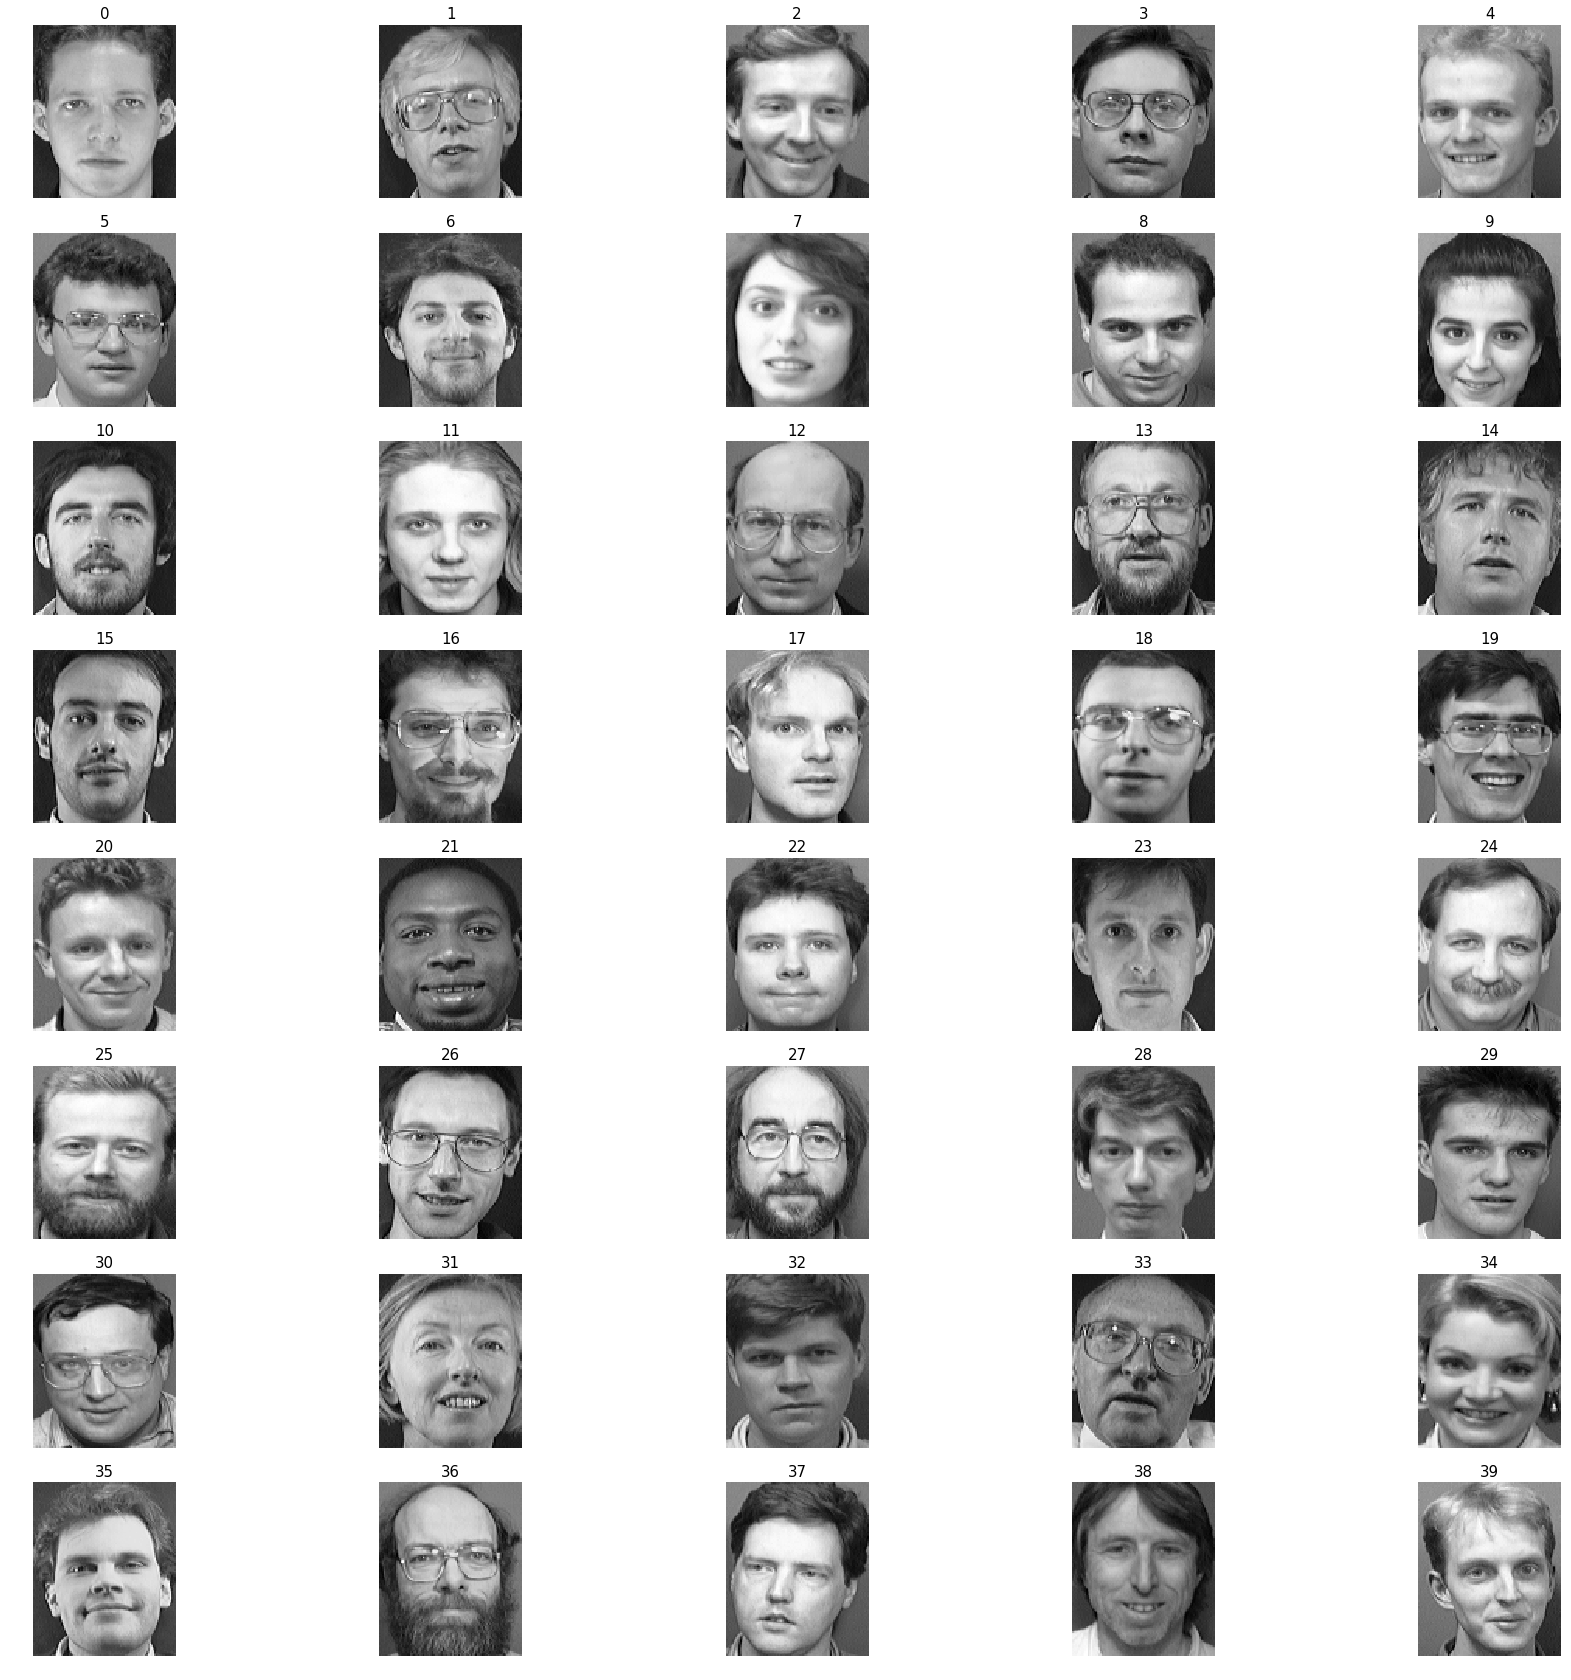

In [5]:
plt.figure(figsize=(30, 30))
for idx in range(40):
    peridx = np.where(y == idx)[0][0]
    row = idx % 4
    col = int(idx / 4)
    plt.subplot(8, 5, idx + 1)
    plt.title(idx, size=15)
    plt.imshow(X[peridx, :].reshape(112, 92), interpolation='nearest', cmap='gray')
    plt.axis('off')
plt.show()

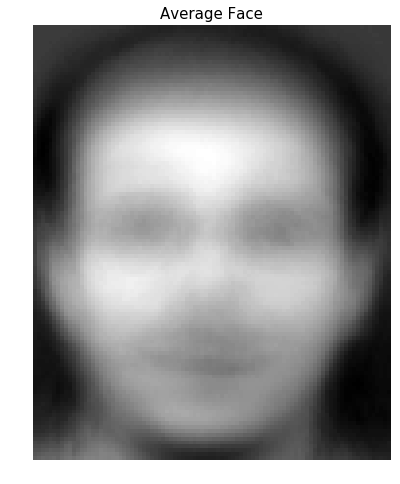

In [6]:
# For future use, lets create a new image comprised by the mean value of each person
mean_face = np.round(np.mean(X, axis=0))
plt.figure(figsize=(8,8))
plt.title("Average Face", size=15)
plt.imshow(mean_face.reshape(112,92), cmap='gray')
plt.axis('off')
plt.show()

We can see that the women are clearly outnumbered in the dataset: 4 to 36.  
So we can perhaps try to classify the people by gender.  
First, we'll re-label our target data and create a binary classification problem $\Rightarrow$ (0,1):  
0 for male and 1 for female.  

Since the labeling is done by a human, therefore the labeling CAN be wrong!  
Our goal is to see if the model thinks the same as we do and will not classify a male as a female and vice-versa
although some individuals by their appearance might seem feminine.

My assumption that all the classes I labeled as "female" are really females.  
My only concern was with no. 11, so to be sure I will show all of his/her images. 

Maybe viewing a different angle will change my mind.

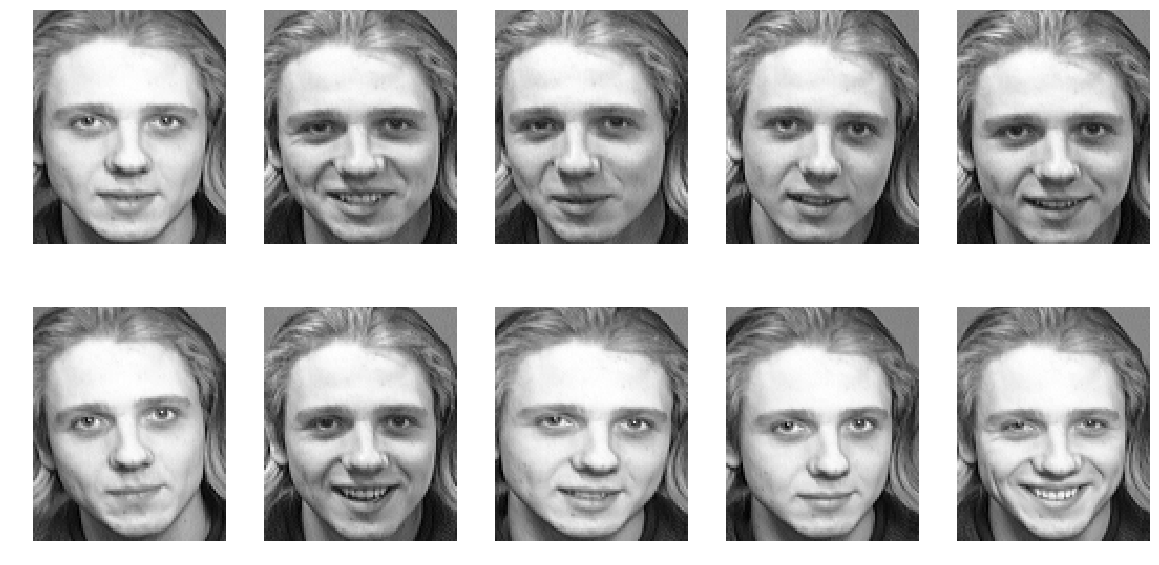

In [7]:
person1 = np.where(y == 11)[0]
plt.figure(figsize=(20, 10))
for idx, peridx in enumerate(person1):
    row = idx % 4
    col = int(idx / 4)
    plt.subplot(2, 5, idx + 1)
    plt.imshow(X[peridx, :].reshape(112, 92), interpolation='nearest', cmap='gray')
    plt.axis('off')
plt.show()

As I persumed, it is a male (judging from the rest of the images).  
Lets begin building our model, but first we need to process our data.  
Since the size of our feature vector is too large for a model to train on, 
we'll use the PCA (Principal Component Analysis) algorithm to reduce the dimensions
of our dataset to a more suitable dimension.  

In [8]:
# Its important to normalize your data between 0 and 1 since classifiers cant destinguish what our data "Truely" means.
# Because our data is nominal therefore it might think that 250 is A LOT better than 1.
# that's why we normalize our data, so each data is scaled down between 0 - 1

print("# of features before PCA:{}".format(X.shape[1]))
norm = Normalizer()
X_norm = norm.fit_transform(X)

# We'll use this data for the remainder of the script
pca = PCA(.95, random_state=42)
X_pca = pca.fit_transform(X_norm)
print("# of features after PCA while retaining 95% of the data:{}".format(X_pca.shape[1]))

# Lets use our trained pca algorithm to transform the mean face image
mean_face_pca = pca.transform(mean_face.reshape(1,-1))

# of features before PCA:10304
# of features after PCA while retaining 95% of the data:202


Now lets try to see if there's any unique behaviour to our data.  
Lets visualize the data in 3D.

**NOTE**: this isn't as useful because we saw earlier that 95% of the data is comprised of 202 eigen vectors, so taking only 3 components might reduce our data drasticaly.

so for the sake of it, lets see how much variance each of the first 3 vectors holds:

In [9]:
sum_variance = 0
for i in range(3):
    print("Eigen Vecotr No. {}, Carries {}% Total Variance".format(i, pca.explained_variance_ratio_[i]))
    sum_variance += pca.explained_variance_ratio_[i]
print("\nTotal Data Covered:", sum_variance)

Eigen Vecotr No. 0, Carries 0.17153179635229293% Total Variance
Eigen Vecotr No. 1, Carries 0.07796811672287077% Total Variance
Eigen Vecotr No. 2, Carries 0.07372384642496545% Total Variance

Total Data Covered: 0.32322375950012916


We can see that our first 3 components hold only 32% of the total data.

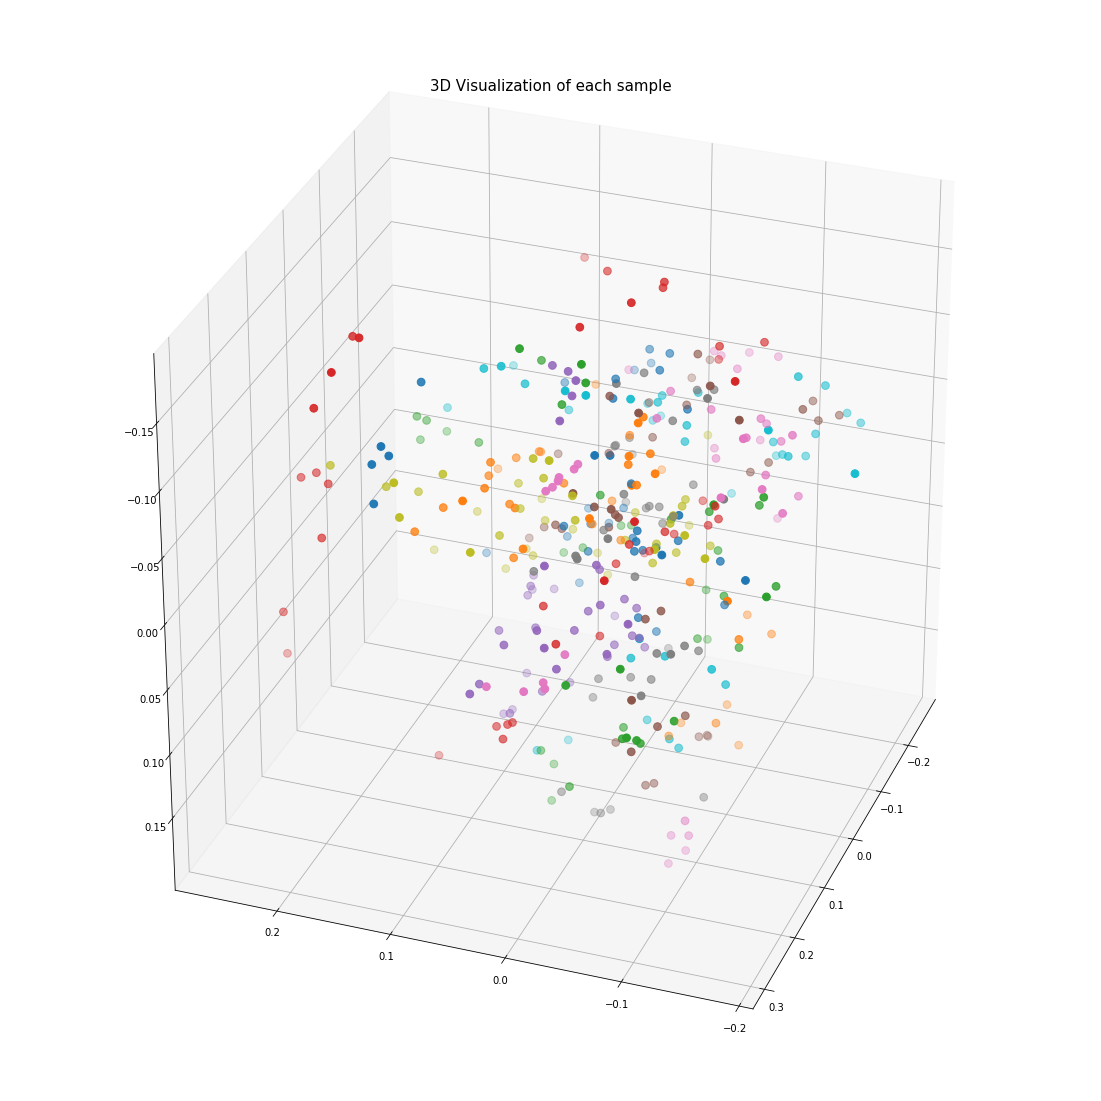

In [10]:
fig = plt.figure(1, figsize=(15, 15))
ax = Axes3D(fig, elev=-150, azim=160)
plt.title("3D Visualization of each sample", size = 15)
for face in range(40):
    ax.scatter(X_pca[:,0][y == face], X_pca[:,1][y == face], X_pca[:, 2][y == face],s=60)
plt.show()

Lets try to cluster our preprocessed data, first we can use hierarchy clustering and see via a dendrogram just how many optimal clusters are needed.

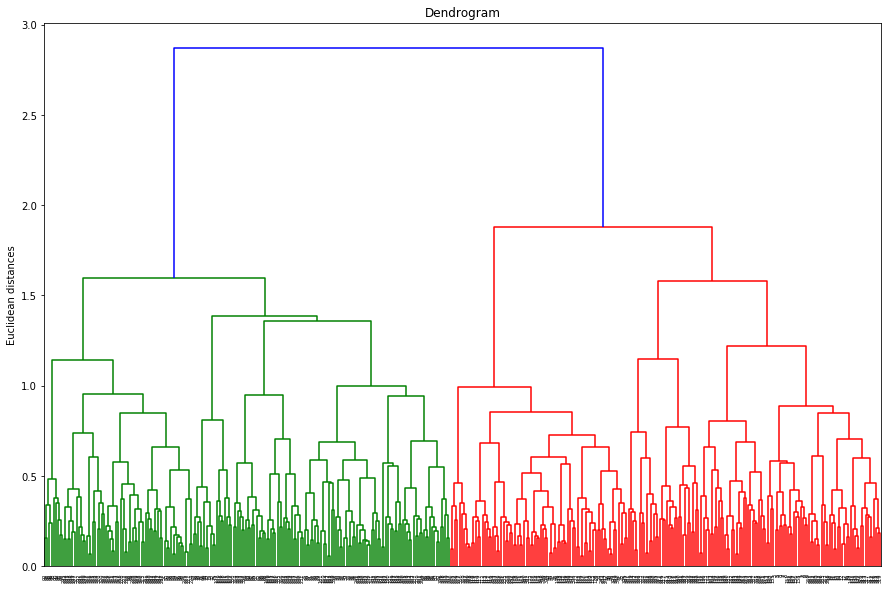

In [11]:
plt.figure(figsize=(15,10))
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
dendrogram = sch.dendrogram(sch.linkage(X_pca, method = 'ward'))
plt.show()


We can see that 2-3 clusters might seem to fit this data, lets check using the "Elbow" method:

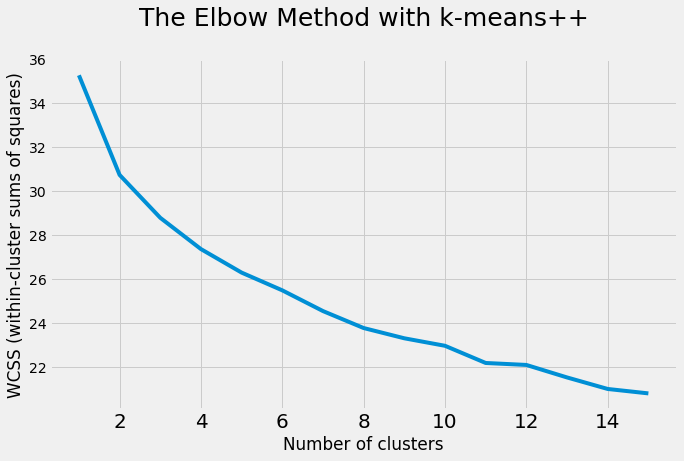

In [12]:
wcss = []
for i in range(1, 16):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

with plt.style.context(('fivethirtyeight')):
    plt.figure(figsize=(10,6))
    plt.plot(range(1, 16), wcss)
    plt.title('The Elbow Method with k-means++\n',fontsize=25)
    plt.xlabel('Number of clusters')
    plt.xticks(fontsize=20)
    plt.ylabel('WCSS (within-cluster sums of squares)')
    plt.show()

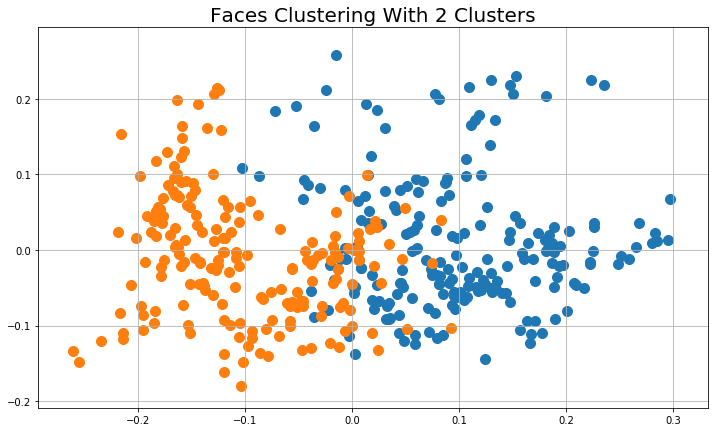

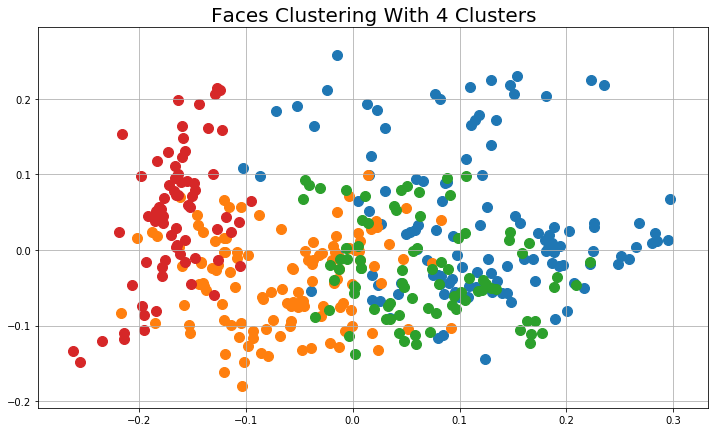

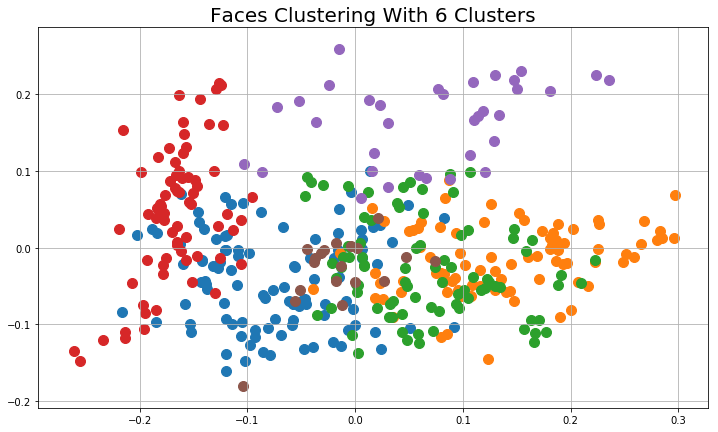

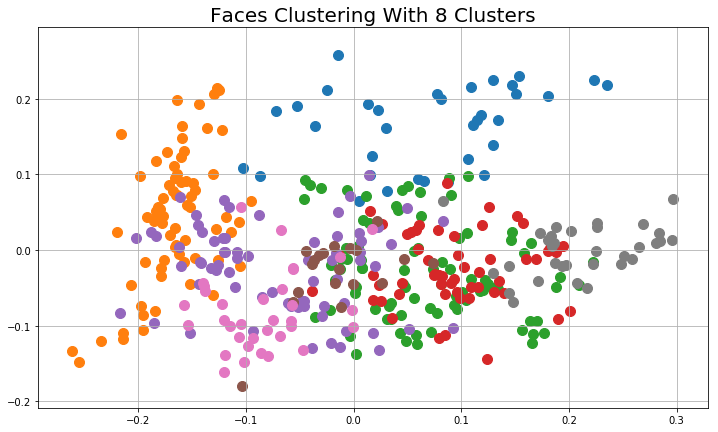

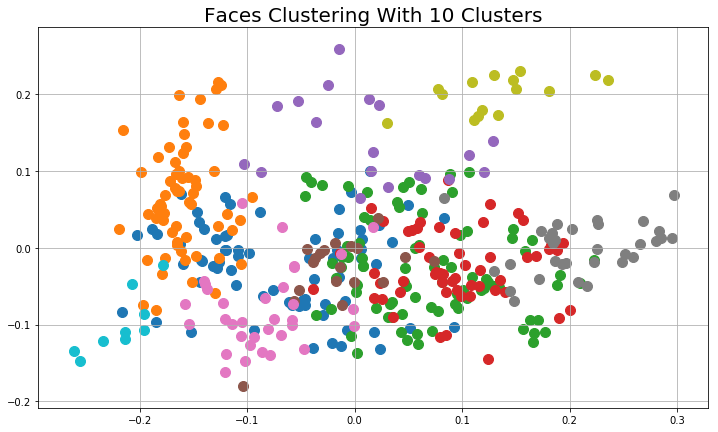

In [13]:
n_clusters = np.arange(2,12,2)

for cluster in n_clusters:
    hc = AgglomerativeClustering(n_clusters = cluster, affinity = 'euclidean', linkage = 'ward')
    y_hc = hc.fit_predict(X_pca)

    plt.figure(figsize=(12,7))
    for clus in range(cluster):
        ax = plt.scatter(X_pca[y_hc == clus, 0], X_pca[y_hc == clus, 1] , s = 100)

    plt.title('Faces Clustering With {} Clusters'.format(cluster),fontsize=20)
    plt.grid(True)
    plt.show()

Lets visualize our first eigen vectors.  

These eigen vectors carry the most data since the variance in them is the largest.

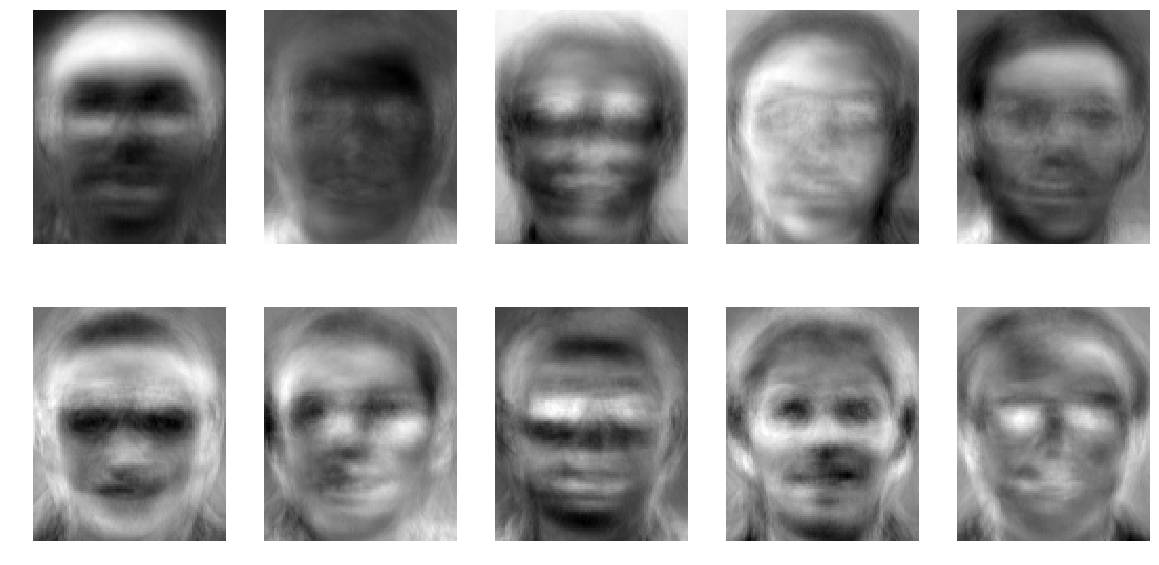

In [14]:
plt.figure(figsize=(20,10))
for idx in range(10):
    plt.subplot(2,5,idx + 1)
    plt.imshow(pca.components_[idx,:].reshape(112,92),cmap='gray')
    plt.axis('off')
plt.show()

## Gender Classification

In [15]:
log_reg = ModelCreator(model_name='logistic_regression', data=X_pca, target=y)
binary_y = log_reg.binary_labeling(subjects=[7, 9, 31, 34])
X_train, X_test, y_train, y_test = log_reg.split(data=log_reg.data, target=binary_y)
params = {'random_state':42, 'C':100, 'gamma':2}
clf = log_reg.fit_model(model_name=log_reg.model_name, data=X_train, target=y_train, params=params)
log_reg.evaluate(classifier=clf, data=X_test, target = y_test)
print("K-Fold Cross Validation Accuracy Score :", np.mean(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')))

Fitting Model:
logistic_regression

Evaluating Model:
Model Accuracy Score: 0.9875

# === Confusion Matrix === #
 [[71  0]
 [ 1  8]]

		# === Classification Report === #

              precision    recall  f1-score   support

        0.0       0.99      1.00      0.99        71
        1.0       1.00      0.89      0.94         9

avg / total       0.99      0.99      0.99        80

K-Fold Cross Validation Accuracy Score : 0.9562438905180841


In [16]:
svm = ModelCreator(model_name='linear_svm', data=X_pca, target=y)
binary_y = svm.binary_labeling(subjects=[7,9,31,34])
X_train, X_test, y_train, y_test = svm.split(data=svm.data, target=binary_y)

params = {'random_state':42, 'C':8, 'gamma':1}
clf = svm.fit_model(model_name=svm.model_name, data=X_train, target=y_train, params=params)
svm.evaluate(classifier=clf, data=X_test, target = y_test)
print("K-Fold Cross Validation Accuracy Score :", np.mean(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')))

Fitting Model:
linear_svm

Evaluating Model:
Model Accuracy Score: 1.0

# === Confusion Matrix === #
 [[71  0]
 [ 0  9]]

		# === Classification Report === #

              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        71
        1.0       1.00      1.00      1.00         9

avg / total       1.00      1.00      1.00        80

K-Fold Cross Validation Accuracy Score : 0.959368890518084


In [17]:
# We can see that when using the linear svm model, without much parameter tuning and minimal cost "C",
# we can out-perform the logistic regression model
# lets try and see what were the most impactful features on the model
svm.coefs(classifier=clf, data=X_train, top_N=20)

Coefficient for top 20 features:

     Attributes  Coefficient
201        10.0     7.689095
200        21.0     4.473573
199         4.0     3.836147
198        25.0     3.784817
197        17.0     3.564340
196        23.0     3.431003
195        14.0     3.264555
194        19.0     3.129646
193         3.0     2.595498
192        82.0     2.593210
191        30.0     2.327635
190       111.0     2.184152
189        18.0     1.992796
188        72.0     1.938385
187        97.0     1.926839
186       170.0     1.903301
185        67.0     1.869664
184        65.0     1.832343
183        74.0     1.799879


In [18]:
# Lets check our classifier on the mean face
print(clf.predict(mean_face_pca)[0])

0.0


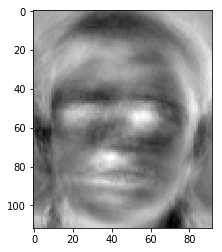

In [19]:
# We can see that the best feature who contributed to the classifier was the 10th eigen vector
# lets plot it

plt.imshow(pca.components_[10,:].reshape(112,92),cmap='gray')
plt.show()

## Facial Features Classification:
### Glasses

In [20]:
# Now lets see if we can reproduce our results with predicting the people who wear glasses
svm = ModelCreator(model_name='linear_svm', data=X_pca, target=y)
binary_y = svm.binary_labeling(subjects=[1,3,5,12,13,16,18,19,26,27,30,33,36])
X_train, X_test, y_train, y_test = svm.split(data=svm.data, target=binary_y)

params = {'random_state':42, 'C':30, 'gamma':2}
clf = svm.fit_model(model_name=svm.model_name, data=X_train, target=y_train, params=params)
svm.evaluate(classifier=clf, data=X_test, target = y_test)
print("K-Fold Cross Validation Accuracy Score :", np.mean(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')))

Fitting Model:
linear_svm

Evaluating Model:
Model Accuracy Score: 0.9625

# === Confusion Matrix === #
 [[58  0]
 [ 3 19]]

		# === Classification Report === #

              precision    recall  f1-score   support

        0.0       0.95      1.00      0.97        58
        1.0       1.00      0.86      0.93        22

avg / total       0.96      0.96      0.96        80

K-Fold Cross Validation Accuracy Score : 0.9158846529814271


In [21]:
svm.coefs(classifier=clf, data=X_train, top_N=20)

Coefficient for top 20 features:

     Attributes  Coefficient
201        21.0     8.689287
200        16.0     7.571231
199        22.0     7.488025
198        49.0     7.062450
197        25.0     6.930885
196         9.0     6.911295
195        28.0     6.570304
194       102.0     6.558068
193        17.0     6.507189
192        29.0     6.174797
191        89.0     6.054590
190        14.0     5.961760
189       118.0     5.819233
188        15.0     5.469139
187       173.0     5.369528
186        95.0     5.291994
185        33.0     5.230922
184        48.0     5.220744
183       145.0     4.913053


In [22]:
svm = ModelCreator(model_name='rbf_svm', data=X_pca, target=y)
binary_y = svm.binary_labeling(subjects=[1,3,5,12,13,16,18,19,26,27,30,33,36])
X_train, X_test, y_train, y_test = svm.split(data=svm.data, target=binary_y)

params = {'random_state':42, 'C':7, 'gamma':2}
clf = svm.fit_model(model_name=svm.model_name, data=X_train, target=y_train, params=params)
svm.evaluate(classifier=clf, data=X_test, target = y_test)
print("K-Fold Cross Validation Accuracy Score :", np.mean(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')))

Fitting Model:
rbf_svm

Evaluating Model:
Model Accuracy Score: 1.0

# === Confusion Matrix === #
 [[58  0]
 [ 0 22]]

		# === Classification Report === #

              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        58
        1.0       1.00      1.00      1.00        22

avg / total       1.00      1.00      1.00        80

K-Fold Cross Validation Accuracy Score : 0.9528164711632453


In [23]:
# Again, lets use our mean face and see what our classifier says
clf.predict(mean_face_pca)[0]

1.0

We can see that our classifier implies that the mean face person does wear glasses!

### Facial Hair

In [24]:
svm = ModelCreator(model_name='linear_svm', data=X_pca, target=y)
binary_y = svm.binary_labeling(subjects=[6,10,13,15,16,21,24,25,27,36])
X_train, X_test, y_train, y_test = svm.split(data=svm.data, target=binary_y)

params = {'random_state':42, 'C':10, 'gamma':2}
clf = svm.fit_model(model_name=svm.model_name, data=X_train, target=y_train, params=params)
svm.evaluate(classifier=clf, data=X_test, target = y_test)
print("K-Fold Cross Validation Accuracy Score :", np.mean(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')))

Fitting Model:
linear_svm

Evaluating Model:
Model Accuracy Score: 0.9625

# === Confusion Matrix === #
 [[67  1]
 [ 2 10]]

		# === Classification Report === #

              precision    recall  f1-score   support

        0.0       0.97      0.99      0.98        68
        1.0       0.91      0.83      0.87        12

avg / total       0.96      0.96      0.96        80

K-Fold Cross Validation Accuracy Score : 0.9276973362658847


In [25]:
svm.coefs(classifier=clf, data=X_train, top_N=20)

Coefficient for top 20 features:

     Attributes  Coefficient
201        22.0     7.474154
200        24.0     7.240348
199         7.0     5.468660
198         4.0     5.000639
197        60.0     4.454915
196        36.0     4.232136
195        27.0     3.900388
194        29.0     3.782813
193         8.0     3.750592
192        31.0     3.697559
191        46.0     3.691540
190         5.0     3.657935
189        96.0     3.515602
188        20.0     3.512721
187        14.0     3.375769
186        57.0     3.305011
185         0.0     3.287545
184        93.0     3.160238
183        52.0     3.003691


In [26]:
svm = ModelCreator(model_name='rbf_svm', data=X_pca, target=y)
binary_y = svm.binary_labeling(subjects=[6,10,13,15,16,21,24,25,27,36])
X_train, X_test, y_train, y_test = svm.split(data=svm.data, target=binary_y)

params = {'random_state':42, 'C':10, 'gamma':2}
clf = svm.fit_model(model_name=svm.model_name, data=X_train, target=y_train, params=params)
svm.evaluate(classifier=clf, data=X_test, target = y_test)
print("K-Fold Cross Validation Accuracy Score :", np.mean(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')))

Fitting Model:
rbf_svm

Evaluating Model:
Model Accuracy Score: 0.975

# === Confusion Matrix === #
 [[67  1]
 [ 1 11]]

		# === Classification Report === #

              precision    recall  f1-score   support

        0.0       0.99      0.99      0.99        68
        1.0       0.92      0.92      0.92        12

avg / total       0.97      0.97      0.97        80

K-Fold Cross Validation Accuracy Score : 0.9748930840664712


Although, both classifiers produce great results and quite similar, we can see that our validation score when using the rbf kernel svm, is a bit higher.

# Person Classification
Now lets try to train a classifier which can identify each person.  

**NOTE:** one problem which might occur during this learning process, is that some subjects may not be taken to our test set.

In [27]:
# Lets split our dataset to train & test sets with a 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.2, random_state = 42)
print("# of rows in train set:", X_train.shape[0])
print("# of rows in test set:", X_test.shape[0])
print("\nDiversity in target train set:\n{}".format(y_train.value_counts().sort_index()))
print("\nDiversity in target test set:\n{}".format(y_test.value_counts().sort_index()))

# of rows in train set: 320
# of rows in test set: 80

Diversity in target train set:
0      7
1      9
2      8
3      6
4      7
5      7
6     10
7      4
8      8
9      8
10     8
11     7
12     8
13     9
14     7
15     8
16    10
17     7
18     9
19     9
20     9
21     9
22     7
23     8
24     9
25     9
26     6
27     8
28     8
29     9
30    10
31    10
32     7
33     9
34     9
35     9
36     8
37     8
38     6
39     6
Name: target, dtype: int64

Diversity in target test set:
0     3
1     1
2     2
3     4
4     3
5     3
7     6
8     2
9     2
10    2
11    3
12    2
13    1
14    3
15    2
17    3
18    1
19    1
20    1
21    1
22    3
23    2
24    1
25    1
26    4
27    2
28    2
29    1
32    3
33    1
34    1
35    1
36    2
37    2
38    4
39    4
Name: target, dtype: int64


As I've mentioned, some images were not selected to our test set, the following ID's are not contained in the test set: [6,16,30,31]

In [28]:
svm = ModelCreator(model_name='rbf_svm', data=X_pca, target=y)

params = {'random_state':42, 'C':10, 'gamma':2}
clf = svm.fit_model(model_name=svm.model_name, data=X_train, target=y_train, params=params)
svm.evaluate(classifier=clf, data=X_test, target = y_test)
print("K-Fold Cross Validation Accuracy Score :", np.mean(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')))

Fitting Model:
rbf_svm

Evaluating Model:
Model Accuracy Score: 0.9875

# === Confusion Matrix === #
 [[3 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 3]]

		# === Classification Report === #

              precision    recall  f1-score   support

          0       1.00      1.00      1.00         3
          1       1.00      1.00      1.00         1
          2       1.00      1.00      1.00         2
          3       1.00      1.00      1.00         4
          4       0.75      1.00      0.86         3
          5       1.00      1.00      1.00         3
          7       1.00      1.00      1.00         6
          8       1.00      1.00      1.00         2
          9       1.00      1.00      1.00         2
         10       1.00      1.00      1.00         2
         11       1.00      1.00      1.00         3
         12       1.00      1.00      1.00         2
         13       1.00      1.00      1.00       

We can see that our classifier was able to identify each person extremely well!  
Except person no. 39, lets look at the confusion matrix and see with whom the classifier confused him with.

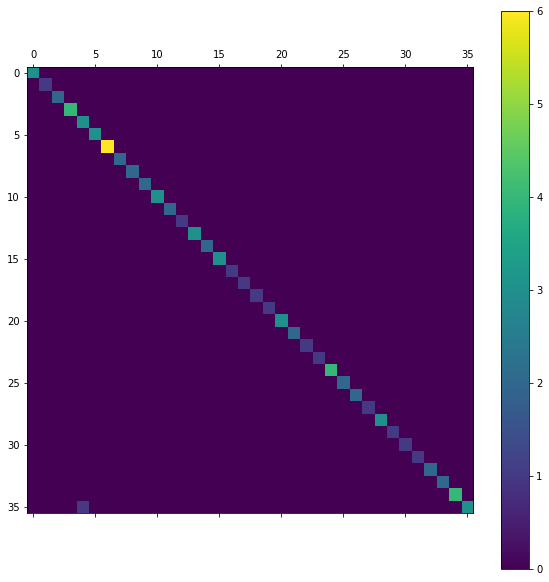

In [29]:
plt.figure(figsize=(10,10))
plt.matshow(confusion_matrix(y_pred=clf.predict(X_test), y_true=y_test), fignum=1)
plt.colorbar()
plt.show()

We can see that our model mixed up a bit between no.4 and no.39 $\Rightarrow$ that explains the lower precision for no.4  
Lets try using a different classifier and see if we can fix this.

In [30]:
svm = ModelCreator(model_name='linear_svm', data=X_pca, target=y)

params = {'random_state':42, 'C':10, 'gamma':2}
clf = svm.fit_model(model_name=svm.model_name, data=X_train, target=y_train, params=params)
svm.evaluate(classifier=clf, data=X_test, target = y_test)
print("K-Fold Cross Validation Accuracy Score :", np.mean(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')))

Fitting Model:
linear_svm

Evaluating Model:
Model Accuracy Score: 0.975

# === Confusion Matrix === #
 [[2 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 3]]

		# === Classification Report === #

              precision    recall  f1-score   support

          0       1.00      0.67      0.80         3
          1       1.00      1.00      1.00         1
          2       1.00      1.00      1.00         2
          3       1.00      1.00      1.00         4
          4       0.75      1.00      0.86         3
          5       1.00      1.00      1.00         3
          7       1.00      1.00      1.00         6
          8       1.00      1.00      1.00         2
          9       1.00      1.00      1.00         2
         10       1.00      1.00      1.00         2
         11       1.00      1.00      1.00         3
         12       1.00      1.00      1.00         2
         13       1.00      1.00      1.00     

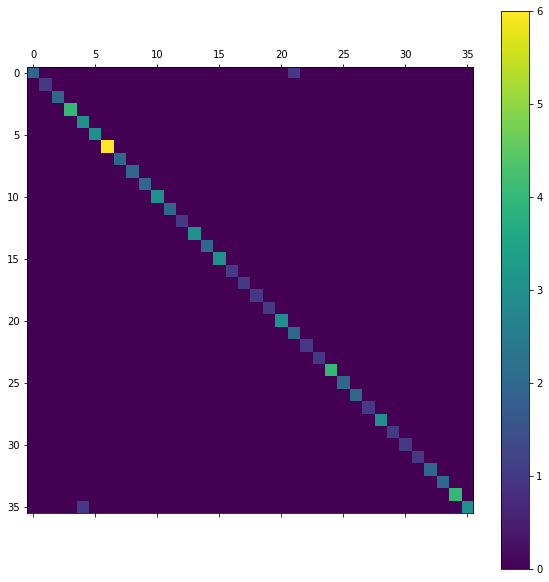

In [31]:
plt.figure(figsize=(10,10))
plt.matshow(confusion_matrix(y_pred=clf.predict(X_test), y_true=y_test), fignum=1)
plt.colorbar()
plt.show()

Now we can see that our model is even less correct, classifying no.1 as no.23.  
None the less, both classifiers produced good results, lets see which feature contributed the most.

In [32]:
svm.coefs(clf, data=X_train, top_N=20)

Coefficient for top 20 features:

     Attributes  Coefficient
201         4.0     3.879480
200         3.0     3.367675
199        20.0     2.172703
198        27.0     1.988328
197        30.0     1.731240
196         6.0     1.719318
195        33.0     1.540692
194        12.0     1.506751
193        32.0     1.503544
192         8.0     1.457587
191        19.0     1.438065
190        34.0     1.393946
189        10.0     1.378405
188         0.0     1.314795
187        16.0     1.293831
186        90.0     1.287704
185        54.0     1.273741
184        48.0     1.263908
183        61.0     1.173942


It seems like the 4th eigen vector was the most useful to our model, with the 3rd contributing a bit less.  
Lets plot both of these eigen vectors.

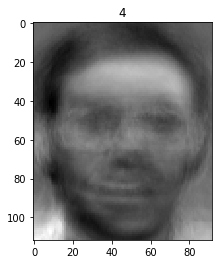

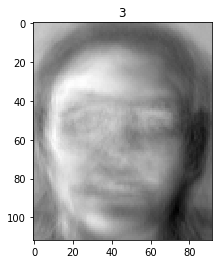

In [33]:
plt.title('4')
plt.imshow(pca.components_[4,:].reshape(112,92), cmap='gray')
plt.show()

plt.title('3')
plt.imshow(pca.components_[3,:].reshape(112,92), cmap='gray')
plt.show()

As mentioned before, lets try to use our mean face and see which person does he look like the most and we'll compare them side-by-side:

Predicted Most Similar Person for Mean Face Image: 4


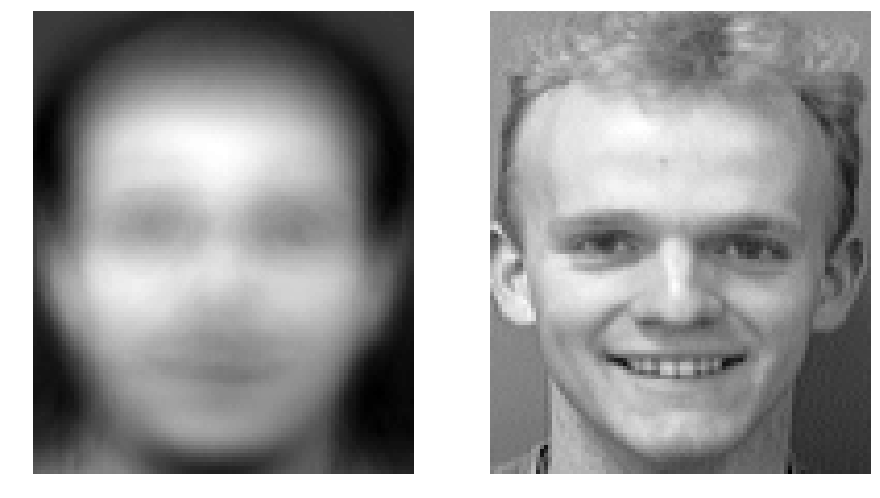

In [34]:
print("Predicted Most Similar Person for Mean Face Image: {}".format(clf.predict(mean_face_pca)[0]))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(mean_face.reshape(112,92),cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(X[(clf.predict(mean_face_pca)[0] * 10) + 1].reshape(112,92), cmap='gray')
plt.axis('off')
plt.show()

Finally, we will test our trained classifier.

Only this time, we will flip all of our data $180^\circ$.

In [35]:
X_flipped  = X.copy()
for i in range(len(X)):
    img = X_flipped[i].reshape(112,92)
    img = img[-1::-1,:]
    img = img.reshape(X.shape[1],)
    X_flipped[i] = img

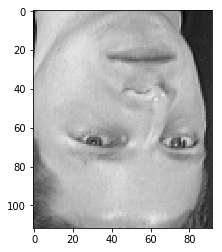

In [36]:
plt.imshow(X_flipped[1].reshape(112,92),cmap='gray')

In [37]:
X_flipped = pca.transform(X_flipped)

In [38]:
svm.evaluate(classifier=clf, data=X_flipped, target = y)


Evaluating Model:
Model Accuracy Score: 0.03

# === Confusion Matrix === #
 [[3 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

		# === Classification Report === #

              precision    recall  f1-score   support

          0       0.50      0.30      0.37        10
          1       0.00      0.00      0.00        10
          2       0.00      0.00      0.00        10
          3       0.00      0.00      0.00        10
          4       0.03      0.90      0.05        10
          5       0.00      0.00      0.00        10
          6       0.00      0.00      0.00        10
          7       0.00      0.00      0.00        10
          8       0.00      0.00      0.00        10
          9       0.00      0.00      0.00        10
         10       0.00      0.00      0.00        10
         11       0.00      0.00      0.00        10
         12       0.00      0.00      0.00        10
         13       0.0

As we can see flipping our images resulted in bad scores (this was quite obvious) since the pre-trained classifier was trained on flipped images, it would be a surprise if it was able to predict well on this set as well.